In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Seed for reproducibility
np.random.seed(42)

# Nonlinear 1D State-Space Model

This example demonstrates a nonlinear state-space model in which we estimate a hidden state $x_t$ over time based on noisy observations $y_t$. The model has the following dynamics:

1. **State Evolution**: 

   $$
   x_t = \frac{x_{t-1}}{2} + 25 \frac{x_{t-1}}{1 + x_{t-1}^2} + 8 \cos(1.2 \cdot t) + v_t
   $$
   where $ v_t \sim \mathcal{N}(0, \sigma_v^2) $.

2. **Observation Model**:
   $$
   y_t = \frac{x_t^2}{20} + r_t
   $$
   where $ r_t \sim \mathcal{N}(0, \sigma_r^2) $.

We’ll compare **Sequential Importance Sampling (SIS)** and **Sequential Importance Resampling (SIR)** to estimate $ x_t $ over time.

In [2]:
# Parameters
N = 100  # Number of particles
T = 200   # Number of time steps
sigma_v = np.sqrt(1)  # Process noise standard deviation
sigma_r = np.sqrt(1)   # Observation noise standard deviation

# Allocate memory for particles, weights, and estimates
x_particles_sis = np.zeros((N, T))    # Particles for SIS
x_particles_sir = np.zeros((N, T))    # Particles for SIR
w_sis = np.ones((N, T)) / N           # Weights for SIS (initially uniform)
w_sir = np.ones((N, T)) / N           # Weights for SIR (initially uniform)
log_w_sis = np.zeros((N, T))          # Log weights for SIS
log_w_sir = np.zeros((N, T))          # Log weights for SIR
x_est_sis = np.zeros(T)               # SIS state estimates
x_est_sir = np.zeros(T)               # SIR state estimates
true_states = np.zeros(T)             # True state values
observations = np.zeros(T)            # Observed values


## Generating True State and Observations

Here we generate the **true state sequence and observations** based on the model dynamics and noise parameters defined above.

**Remember: we aim at recovering/estimating the state given the observations.**


In [3]:
# Initial state
true_states[0] = np.random.normal(0, np.sqrt(10))

# Generate true state and observations
for t in range(1, T):
    true_states[t] = (true_states[t-1] / 2 
                      + 25 * true_states[t-1] / (1 + true_states[t-1]**2) 
                      + 8 * np.cos(1.2 * t) 
                      + np.random.normal(0, sigma_v))
    observations[t] = (true_states[t]**2) / 20 + np.random.normal(0, sigma_r)


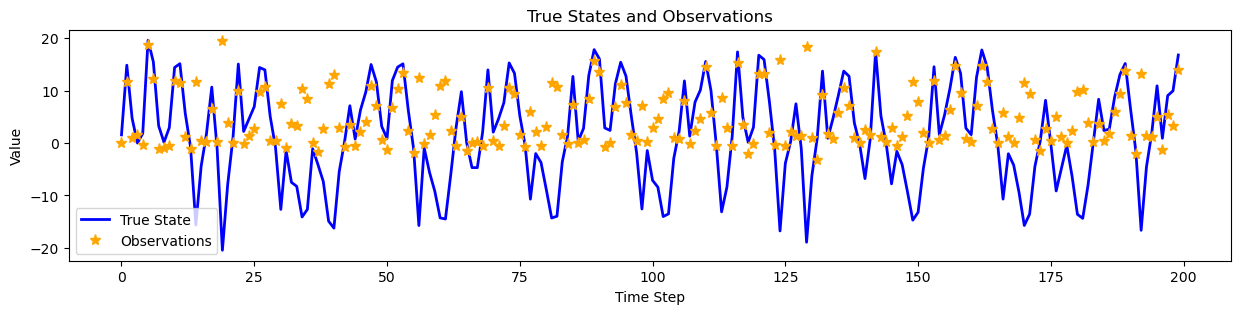

In [4]:
# Generate a time axis for the plot
time_steps = np.arange(T)

# Plot the true states and observations
plt.figure(figsize=(15, 3))
plt.plot(time_steps, true_states, label="True State", color="blue", linewidth=2)
plt.plot(time_steps, observations, '*', label="Observations", color="orange", markersize=8)

# Add labels and legend
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("True States and Observations")
plt.legend()

# Show the plot
plt.show()


## Sequential Importance Sampling (SIS) and Sequential Importance Resampling (SIR)

We will implement both SIS and SIR in parallel. First, we initialize the particles from a prior pdf $p(x_0) \sim \mathcal{N}(0,10)$. Then, in a recursive loop over time, the main steps for the algorithms are:

1. **Prediction Step**: Propagate particles using the state transition model. 
We are sampling $x_t$ given the previous states. Here is were we sample from the proposal, that for simplicity we set as the transition pdf:
$$
q(x_t | x_{t-1}) = p(x_t | x_{t-1}).
$$
**Note**. This choice of proposal is not usually the optimal one, but it is very convenient since it simplifies quite a bit the computation of the weights:
$$
\overline{w}_t(x_t, x_{t-1}) = \frac{p(y_t|x_t) p(x_t|x_{t-1})}{q(x_t|x_{t-1})} w_{t-1} = p(y_t|x_t) w_{t-1}.
$$

2. **Weight Update**: Update weights based on the likelihood of the observation given each particle’s state. For each sample we compute:
$$
\overline{w}_t^{(i)} = p(y_t | x_t^{(i)}) w_{t-1}^{(i)},
$$
and
$$
{w}_{t}^{(i)} = \frac{\overline{w}_{t}^{(i)}}{\sum_{k=1}^{N} \overline{w}_{t}^{(k)}}.
$$

3. **State Estimation**: Compute the state estimate based on the particles and weights. This is the expecation:
$$
\widehat{x}_t = \mathbb{E}_{p(x_{0:t}|y_{1:t})}[ X_t ] \simeq \sum_{i=1}^N x_t^{(i)} w_t^{(i)}.
$$

4. **Resampling (SIR only)**: In SIR, we resample particles to prevent weight degeneracy.

In [5]:
# Initialize particles for SIS and SIR
x_particles_sis[:, 0] = np.random.normal(0, np.sqrt(10), N)  # Initial particles for SIS
x_particles_sir[:, 0] = np.random.normal(0, np.sqrt(10), N)  # Initial particles for SIR

for t in range(1, T):
    # Prediction Step for both SIS and SIR
    for i in range(N):
        # Propagate each particle with process model
        x_particles_sis[i, t] = (x_particles_sis[i, t-1] / 2 
                                 + 25 * x_particles_sis[i, t-1] / (1 + x_particles_sis[i, t-1]**2) 
                                 + 8 * np.cos(1.2 * t) 
                                 + np.random.normal(0, sigma_v))
        
        x_particles_sir[i, t] = (x_particles_sir[i, t-1] / 2 
                                 + 25 * x_particles_sir[i, t-1] / (1 + x_particles_sir[i, t-1]**2) 
                                 + 8 * np.cos(1.2 * t) 
                                 + np.random.normal(0, sigma_v))

         # Update weights based on observation likelihood and previous weights
        #w_sis[i, t] = w_sis[i, t-1] * norm.pdf(observations[t], (x_particles_sis[i, t]**2) / 20, sigma_r)
        #w_sir[i, t] = w_sir[i, t-1] * norm.pdf(observations[t], (x_particles_sir[i, t]**2) / 20, sigma_r)

        # Compute the log of the likelihood for the observation given the particle
        log_likelihood_sis = -0.5 * ((observations[t] - (x_particles_sis[i, t] ** 2) / 20) ** 2) / sigma_r**2
        log_likelihood_sir = -0.5 * ((observations[t] - (x_particles_sir[i, t] ** 2) / 20) ** 2) / sigma_r**2

        # Update log weights by adding log of likelihood (or any importance weight update)
        log_w_sis[i, t] = log_w_sis[i, t-1] + log_likelihood_sis
        log_w_sir[i, t] = log_w_sir[i, t-1] + log_likelihood_sir

    # Normalize log weights for stability (subtract the max log weight before exponentiating)
    max_log_w_sis = np.max(log_w_sis[:, t])
    max_log_w_sir = np.max(log_w_sir[:, t])

    w_sis[:, t] = np.exp(log_w_sis[:, t] - max_log_w_sis)
    w_sir[:, t] = np.exp(log_w_sir[:, t] - max_log_w_sir)
    
    w_sis[:, t] /= np.sum(w_sis[:, t])
    w_sir[:, t] /= np.sum(w_sir[:, t])

    # Estimate the state
    x_est_sis[t] = np.sum(x_particles_sis[:, t] * w_sis[:, t])
    x_est_sir[t] = np.sum(x_particles_sir[:, t] * w_sir[:, t])

    # SIR - Resampling Step
    indices = np.random.choice(N, N, p=w_sir[:, t])  # Resample indices based on weights
    x_particles_sir[:, t] = x_particles_sir[indices, t]  # Resample particles
    w_sir[:, t] = 1 / N  # Reset weights to 1/N
    log_w_sir[:, t] = -np.log(N)


# Results

Now, let’s plot the results to compare the performance of SIS and SIR. We’ll visualize:

## 1. Comparing true state vs. **estimated states**
- Plotting $x_t$ and $\widehat{x}_t$ over time.

- Looking at the **Root Mean Squared Error (RMSE)** of the estimators over time. Its expression is given by:
$$
\text{RMSE}_t = \sqrt{\left( \widehat{x}_t - x_t \right)^2}.
$$
where $ \widehat{x}_t $ is the estimated state at time $ t $, and $ x_t $ is the true state at time $ t $.

- Showing **total RMSE** of both SIS and SIR. It provides a single, summary measure of the estimation error across all time steps, and it is given by:
$$
\text{Total RMSE} = \sqrt{\frac{1}{T} \sum_{t=1}^T \left( \hat{x}_t - x_t \right)^2}
$$
where $ T $ is the total number of time steps.



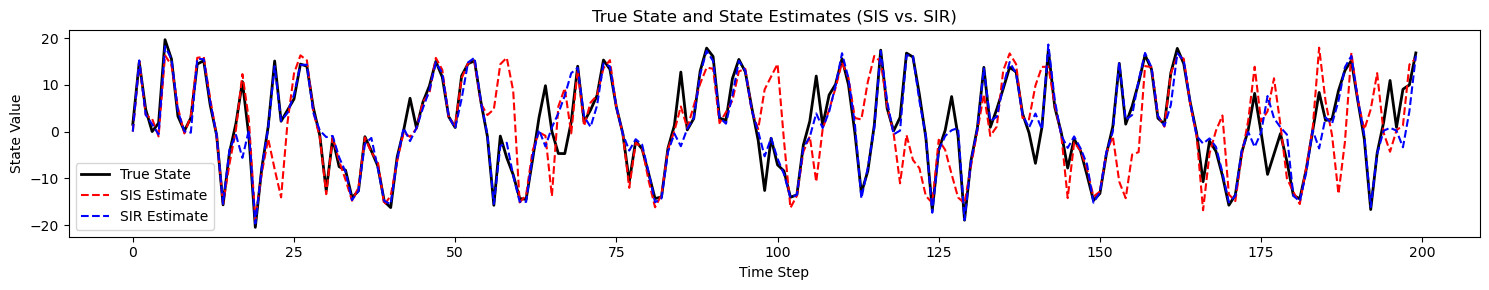

In [6]:
# 1.1. Plot the true state and estimated states from SIS and SIR
plt.figure(figsize=(15, 3))
plt.plot(true_states, label="True State", color="black", linewidth=2)
plt.plot(x_est_sis, label="SIS Estimate", color="red", linestyle="--")
plt.plot(x_est_sir, label="SIR Estimate", color="blue", linestyle="--")
plt.xlabel("Time Step")
plt.ylabel("State Value")
plt.title("True State and State Estimates (SIS vs. SIR)")
plt.legend()

plt.tight_layout()
plt.show()

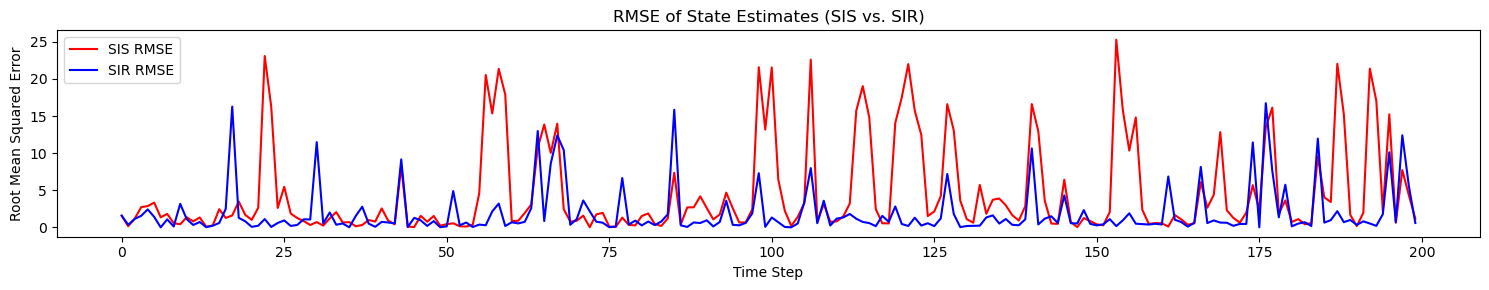

In [7]:
# Calculate RMSE for both SIS and SIR over time
rmse_sis = np.sqrt((x_est_sis - true_states) ** 2)
rmse_sir = np.sqrt((x_est_sir - true_states) ** 2)

# 1.2. Plot the RMSE of the estimates over time for SIS and SIR
plt.figure(figsize=(15, 3))
plt.plot(rmse_sis, '-r', label='SIS RMSE')
plt.plot(rmse_sir, '-b', label='SIR RMSE')
plt.xlabel("Time Step")
plt.ylabel("Root Mean Squared Error")
plt.title("RMSE of State Estimates (SIS vs. SIR)")
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Correct Total RMSE calculation with 1/T
total_rmse_sis = np.sqrt(np.sum((x_est_sis - true_states) ** 2) / T)
total_rmse_sir = np.sqrt(np.sum((x_est_sir - true_states) ** 2) / T)

# 1.3. Display the Total RMSE in the notebook
from IPython.display import display, Markdown

display(Markdown(f"**Total RMSE for SIS**: {total_rmse_sis:.4f}"))
display(Markdown(f"**Total RMSE for SIR**: {total_rmse_sir:.4f}"))


**Total RMSE for SIS**: 7.7828

**Total RMSE for SIR**: 3.7939

## 2. The **weight degeneracy**

- By showing the fraction of particles with **near-zero weights** (below $10^{-3}$) over time.
- By showing the **Effective Sample Size (ESS)** over time. The ESS is a diagnostic to evaluate the effectiveness of a set of particles. ESS provides an estimate of the number of effectively independent samples in the particle set. It helps us determine how well the particles represent the target distribution. A high ESS value indicates a balanced particle set (the maximum value is $N$), while a low ESS value suggests weight degeneracy and the need for resampling. The ESS is given by:
$$
\text{ESS}_t = \frac{1}{\sum_{i=1}^N (w_t^{(i)})^2}
$$
where $ N $ is the number of particles, and $ w_t^{(i)} $ is the normalized weight of particle $ i $ at time $ t $.




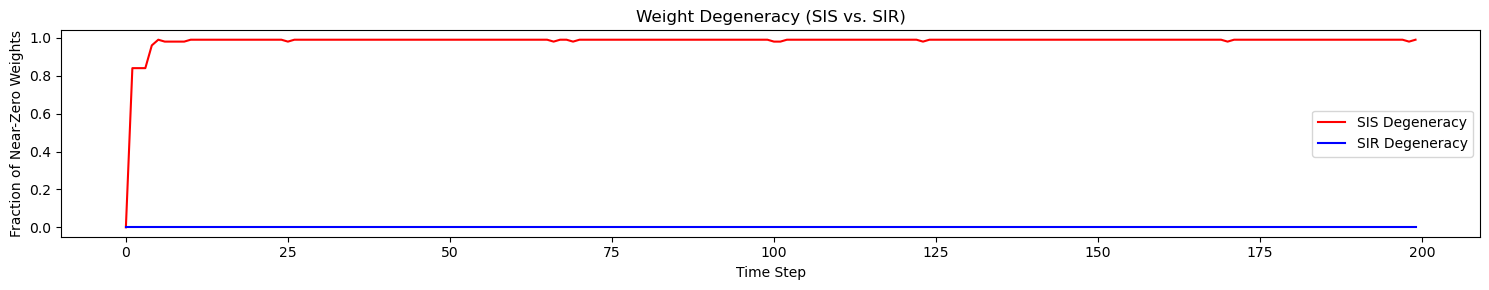

In [9]:
# 2.1. Plot weight degeneracy for SIS and SIR
plt.figure(figsize=(15, 3))
degeneracy_sis = np.sum(w_sis < 1e-3, axis=0) / N
degeneracy_sir = np.sum(w_sir < 1e-3, axis=0) / N
plt.plot(degeneracy_sis, '-r', label='SIS Degeneracy')
plt.plot(degeneracy_sir, '-b', label='SIR Degeneracy')
plt.xlabel("Time Step")
plt.ylabel("Fraction of Near-Zero Weights")
plt.title("Weight Degeneracy (SIS vs. SIR)")
plt.legend()

plt.tight_layout()
plt.show()

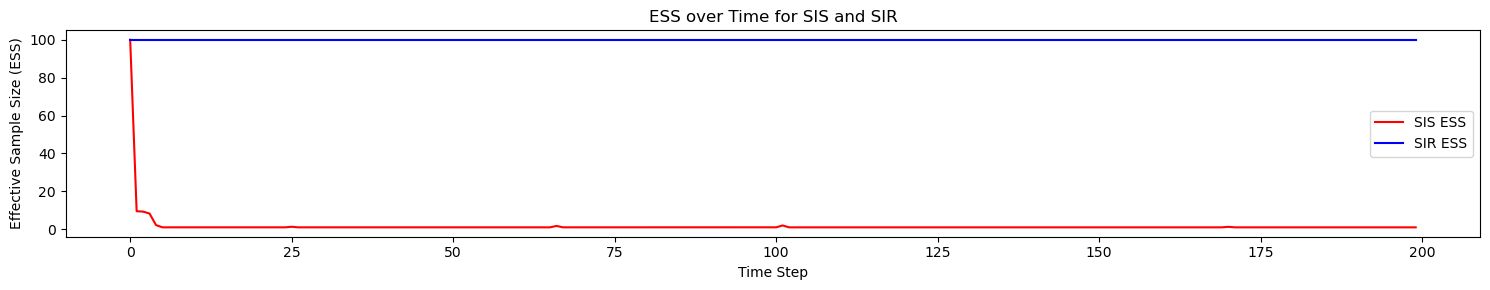

In [8]:
# Calculate ESS over time for SIS and SIR
ess_sis = np.zeros(T)
ess_sir = np.zeros(T)

for t in range(T):
    ess_sis[t] = 1 / np.sum(w_sis[:, t] ** 2)
    ess_sir[t] = 1 / np.sum(w_sir[:, t] ** 2)

# 2.2. Plot ESS over time
plt.figure(figsize=(15, 3))
plt.plot(ess_sis, label="SIS ESS", color="red")
plt.plot(ess_sir, label="SIR ESS", color="blue")
plt.xlabel("Time Step")
plt.ylabel("Effective Sample Size (ESS)")
plt.title("ESS over Time for SIS and SIR")
plt.legend()

plt.tight_layout()
plt.show()


# Understanding Resampling: plotting step by step 

In Sequential Importance Resampling (SIR), resampling is a crucial step that helps to address **weight degeneracy**. Over time, without resampling, many particle weights tend to zero, leading to poor particle diversity and reduced estimation accuracy.

### Key Stages:
1. **Before Weighting**: Particles are sampled i.i.d. from the proposal. In this case, from the transition pdf. 
2. **After Weighting**: Weights are updated based on the likelihood of each particle under the current observation. 
3. **After Resampling (SIR only)**: SIR resamples particles based on their weights, replicating high-weight particles and discarding low-weight ones. After resampling, all particles are assigned equal weights.

By comparing SIS and SIR at a specific time step, we can observe how resampling maintains particle diversity in SIR. The ESS of SIS decreases quickly (having a bunch of particles that have zero weight, so they are useless), while SIR keeps always a set of particles that can be effective in the estimation of the state. 

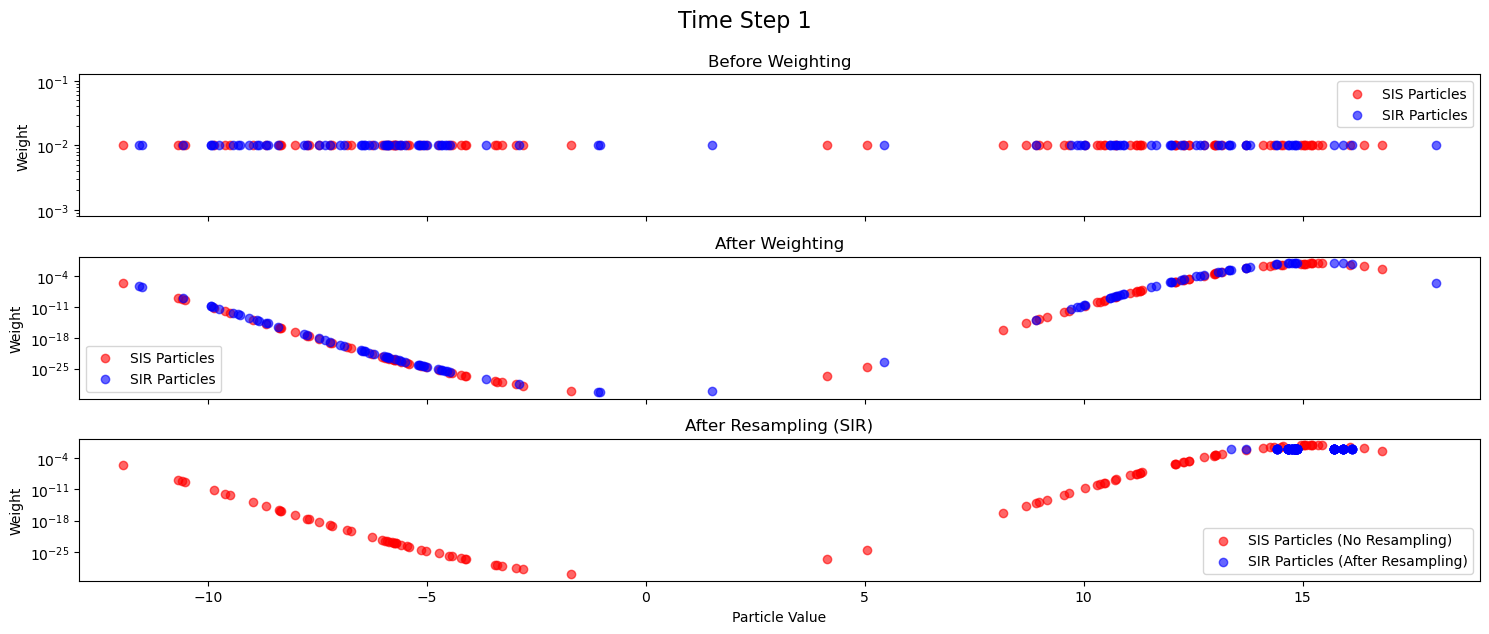

Press Enter to continue to the next time step...


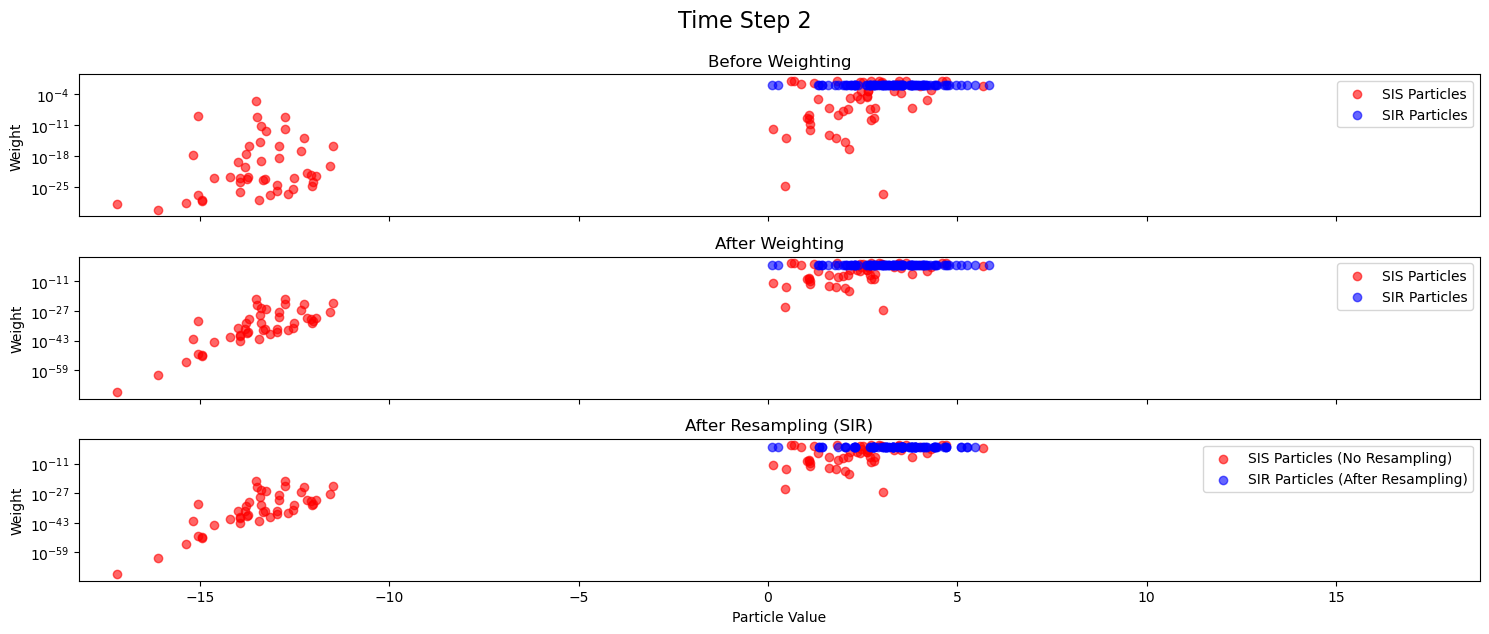

Press Enter to continue to the next time step...


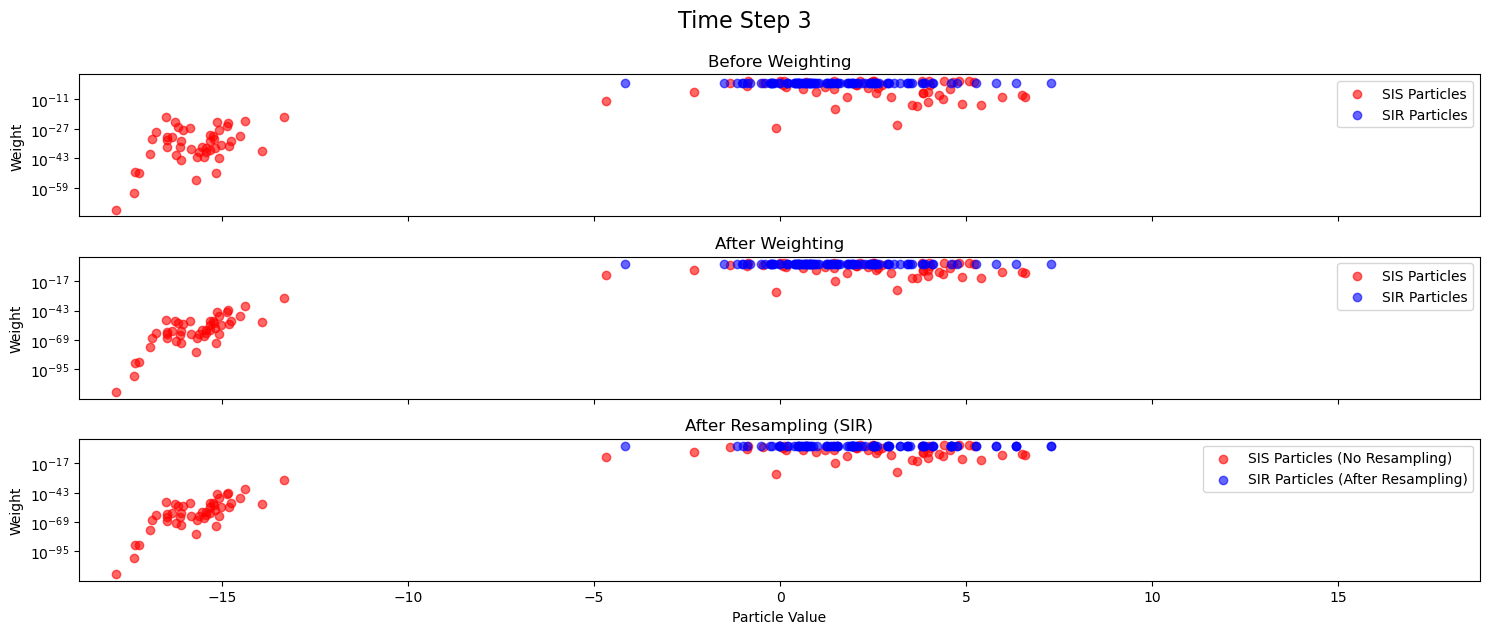

Press Enter to continue to the next time step...


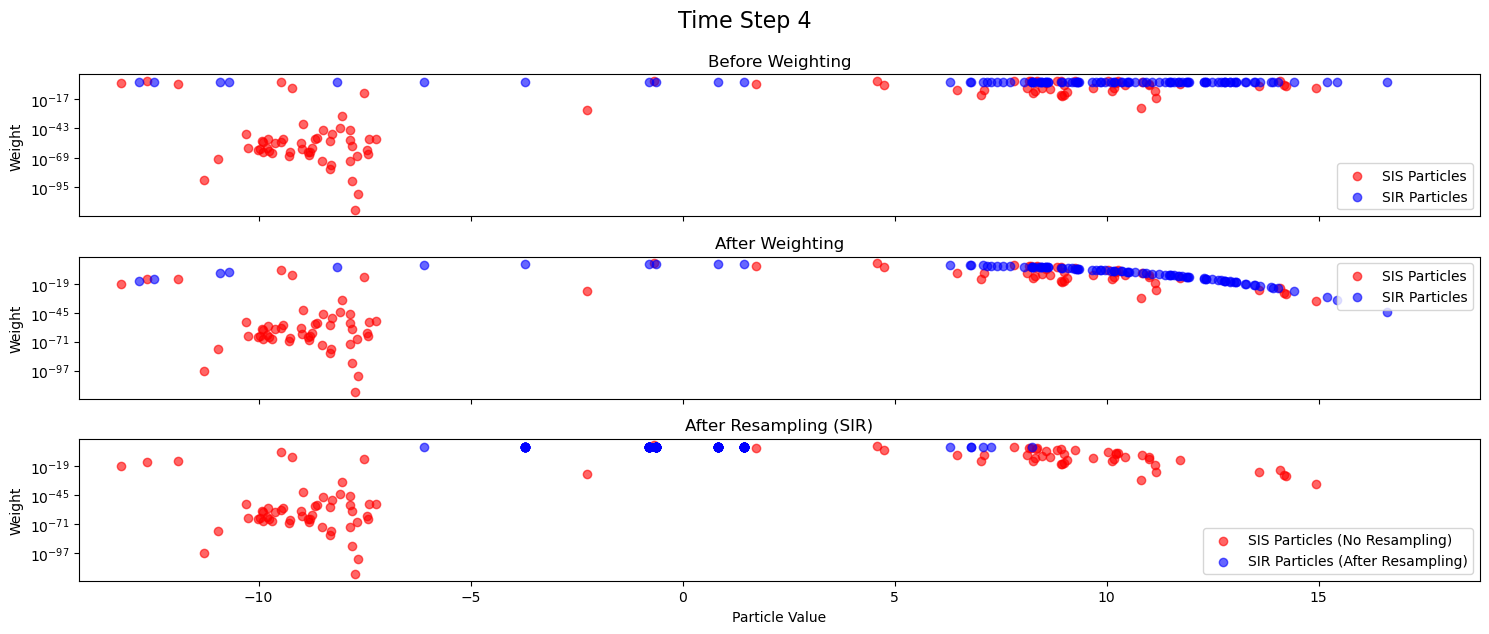

Press Enter to continue to the next time step...


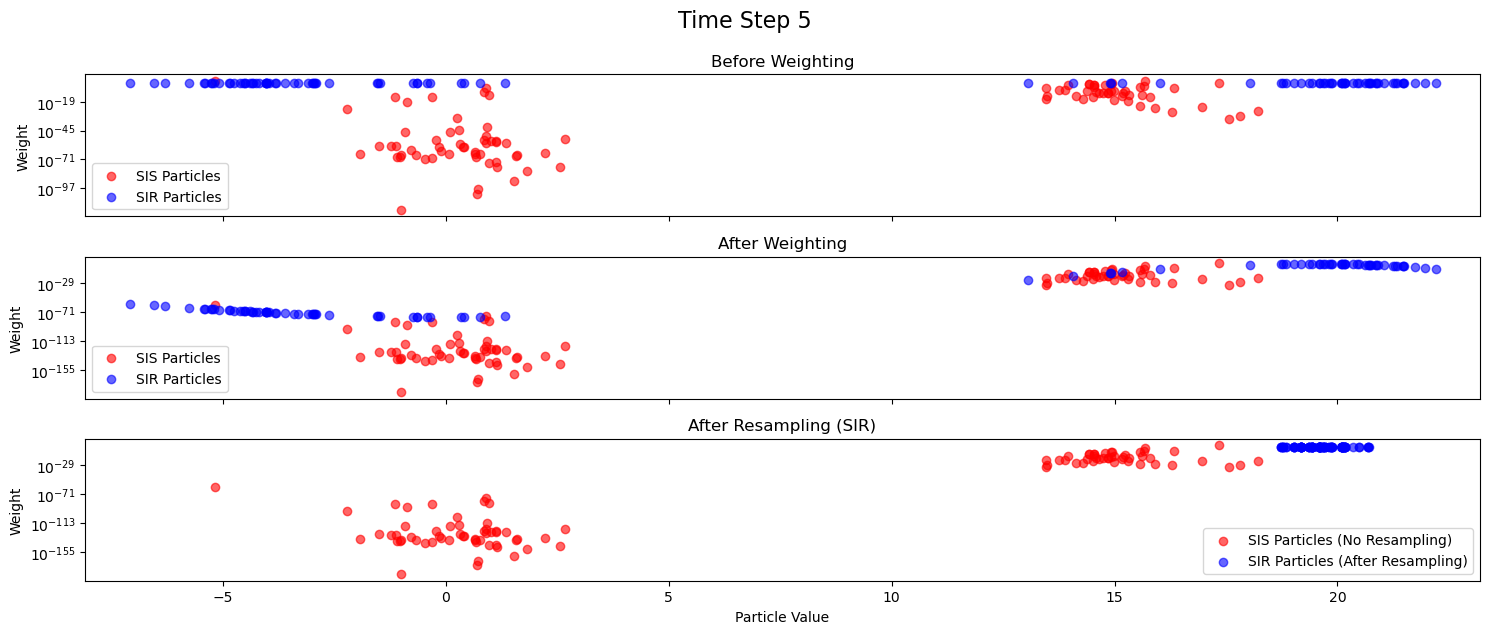

Press Enter to continue to the next time step...


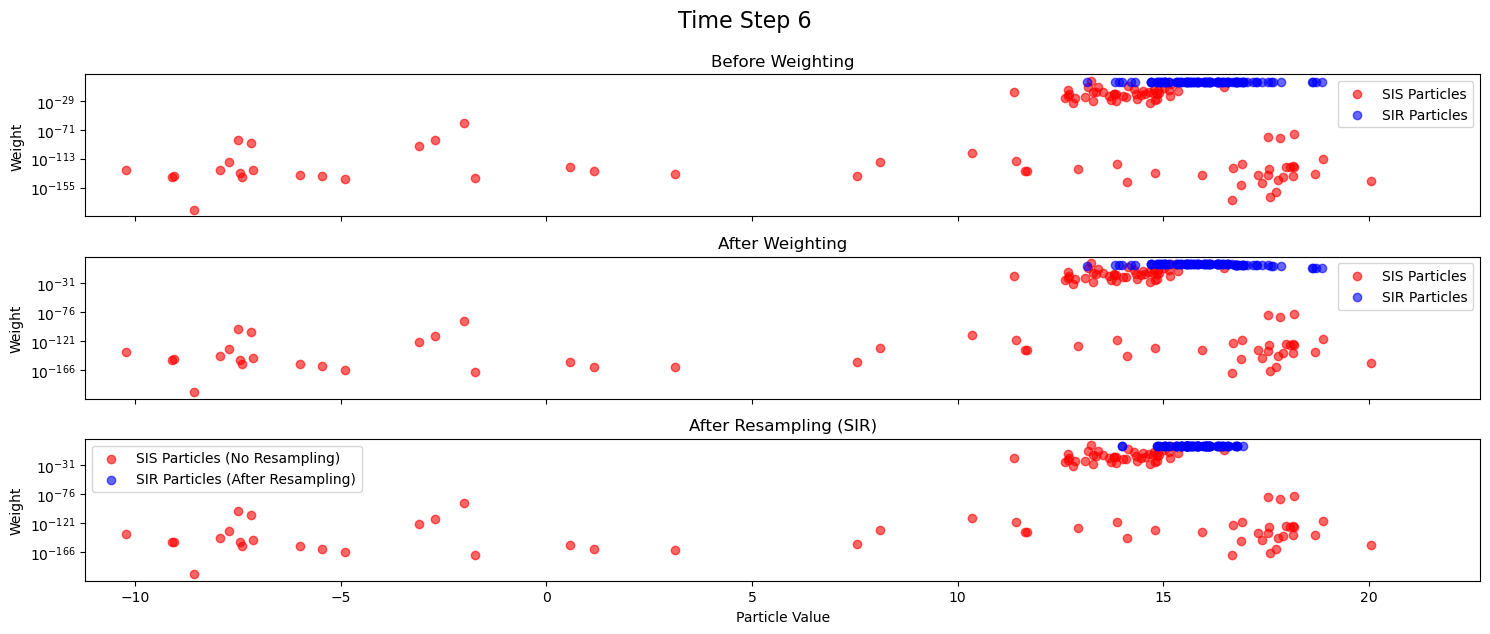

Press Enter to continue to the next time step...


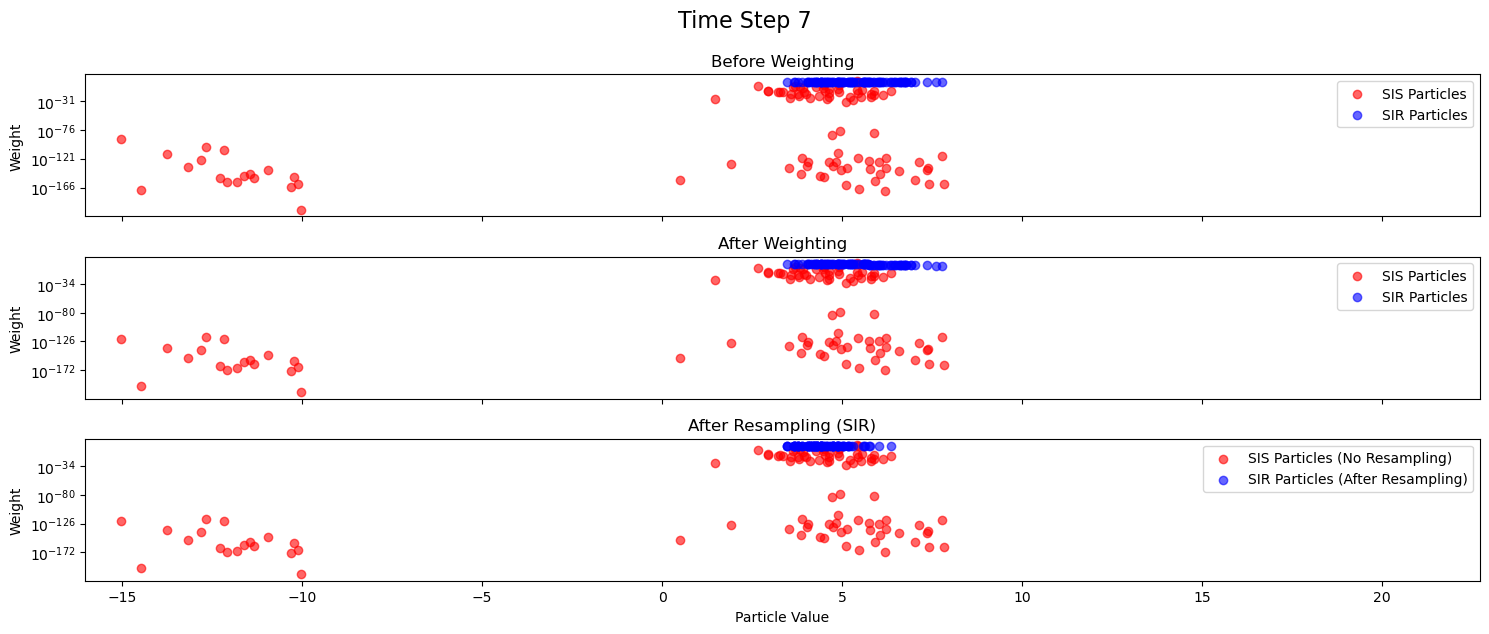

Press Enter to continue to the next time step...


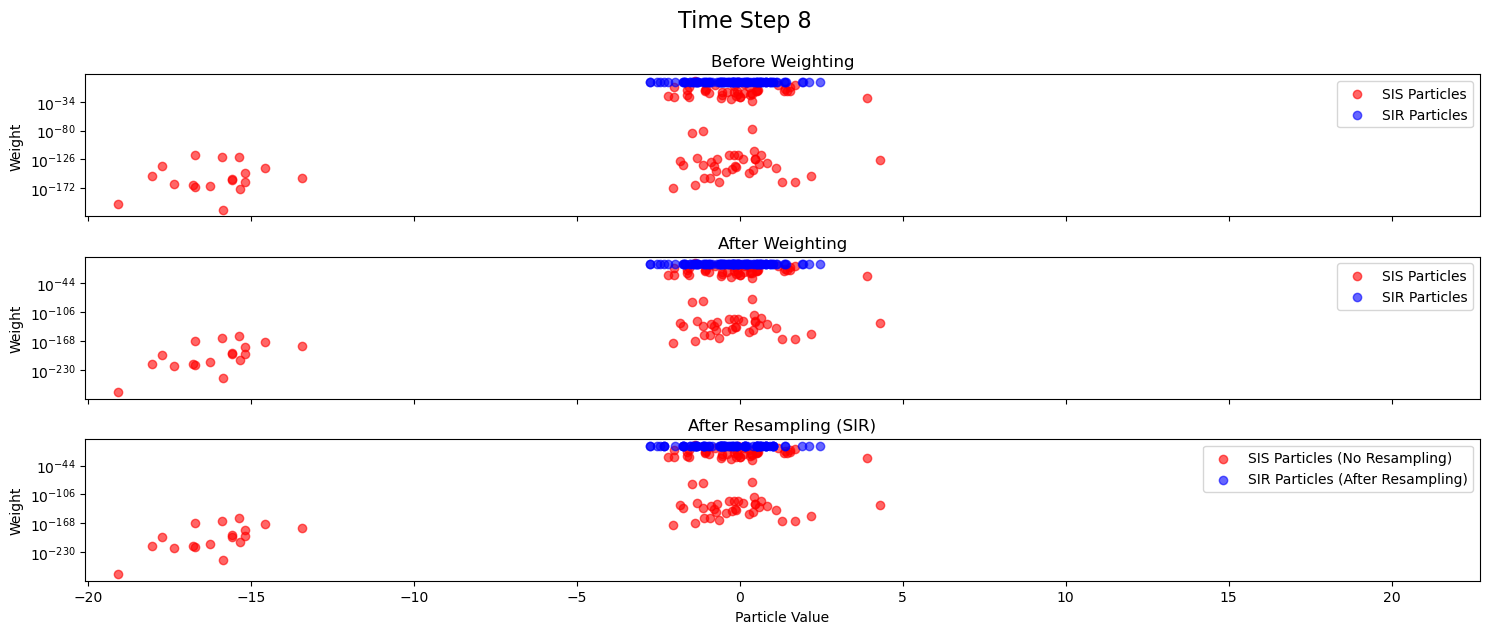

Press Enter to continue to the next time step...


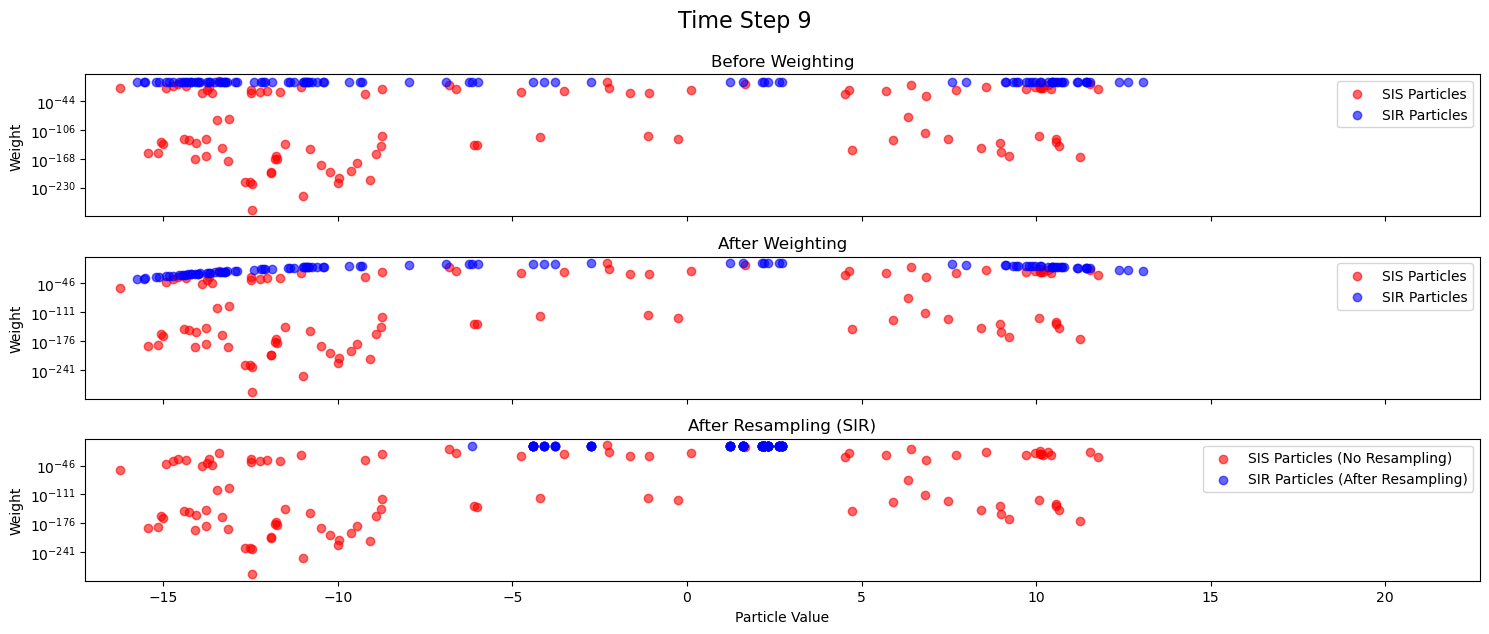

Press Enter to continue to the next time step...


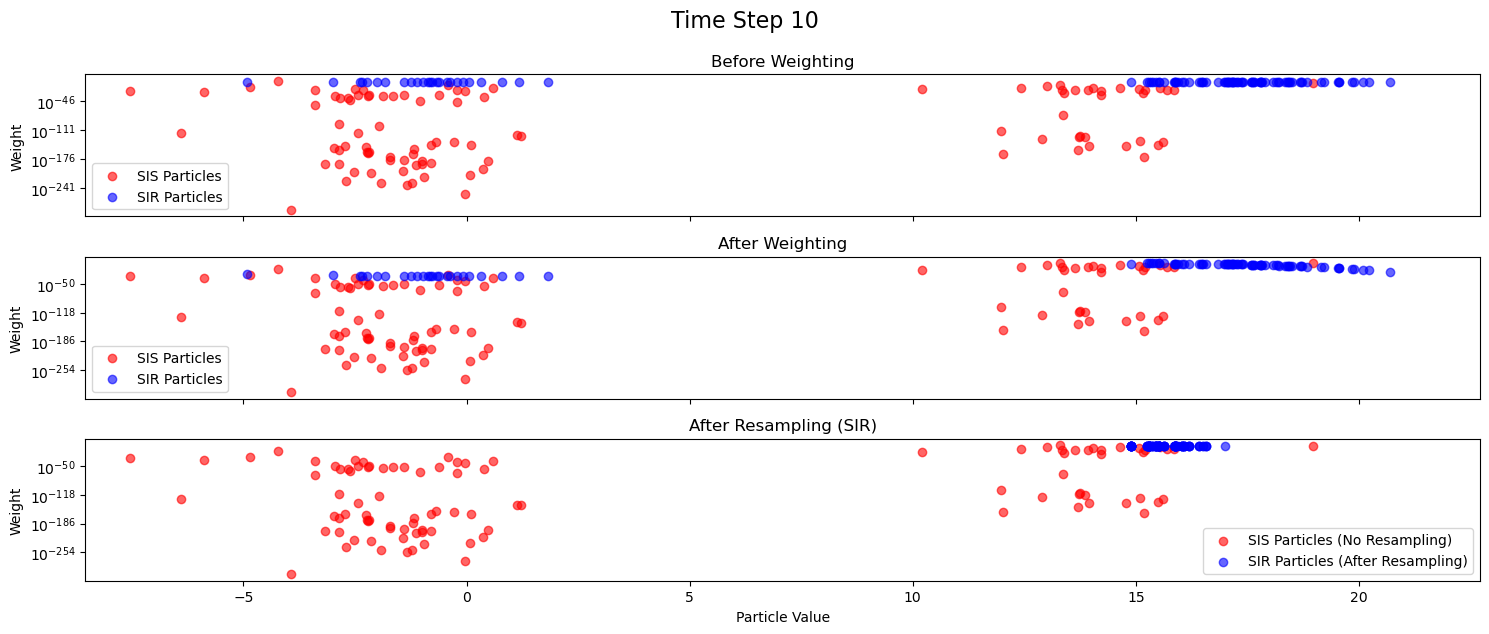

Press Enter to continue to the next time step...


In [11]:
# Step we will plot the particles
num_time_steps = 10

# Initialize particles for SIS and SIR
x_particles_sis[:, 0] = np.random.normal(0, np.sqrt(10), N)  # Initial particles for SIS
x_particles_sir[:, 0] = np.random.normal(0, np.sqrt(10), N)  # Initial particles for SIR

# Loop over the time steps
for t in range(1, num_time_steps + 1):
    # Run SIS and SIR for the current time step `t`
    for i in range(N):
        # Propagate each particle with the process model
        x_particles_sis[i, t] = (x_particles_sis[i, t-1] / 2 
                                 + 25 * x_particles_sis[i, t-1] / (1 + x_particles_sis[i, t-1]**2) 
                                 + 8 * np.cos(1.2 * t) 
                                 + np.random.normal(0, sigma_v))
        
        x_particles_sir[i, t] = (x_particles_sir[i, t-1] / 2 
                                 + 25 * x_particles_sir[i, t-1] / (1 + x_particles_sir[i, t-1]**2) 
                                 + 8 * np.cos(1.2 * t) 
                                 + np.random.normal(0, sigma_v))

        # Compute the log of the likelihood for the observation given the particle
        log_likelihood_sis = -0.5 * ((observations[t] - (x_particles_sis[i, t] ** 2) / 20) ** 2) / sigma_r**2
        log_likelihood_sir = -0.5 * ((observations[t] - (x_particles_sir[i, t] ** 2) / 20) ** 2) / sigma_r**2

        # Update log weights by adding log of likelihood (or any importance weight update)
        log_w_sis[i, t] = log_w_sis[i, t-1] + log_likelihood_sis
        log_w_sir[i, t] = log_w_sir[i, t-1] + log_likelihood_sir

    # Normalize log weights for stability (subtract the max log weight before exponentiating)
    max_log_w_sis = np.max(log_w_sis[:, t])
    max_log_w_sir = np.max(log_w_sir[:, t])

    w_sis[:, t] = np.exp(log_w_sis[:, t] - max_log_w_sis)
    w_sir[:, t] = np.exp(log_w_sir[:, t] - max_log_w_sir)
    
    w_sis[:, t] /= np.sum(w_sis[:, t])
    w_sir[:, t] /= np.sum(w_sir[:, t])

    # Save the current SIR weights and particles before resampling (for plotting)
    weights_sir_before_resampling = w_sir[:, t].copy()
    particles_sir_before_resampling = x_particles_sir[:, t].copy()

    # Resampling step for SIR
    indices = np.random.choice(N, N, p=w_sir[:, t])  # Resample indices based on weights
    x_particles_sir[:, t] = x_particles_sir[indices, t]  # Resample particles
    w_sir[:, t] = 1 / N  # Reset weights to 1/N after resampling
    log_w_sir[:,t] = np.log(N)

    # Determine common x-axis limits based on the range of particle values across both algorithms
    x_min = min(x_particles_sis[:,t].min(), x_particles_sir[:,t].min())
    x_min = min(x_min, particles_sir_before_resampling.min())-1
    x_max = max(x_particles_sis[:, :t].max(), x_particles_sir[:, :t].max())+1
    x_max = max(x_max, particles_sir_before_resampling.max())+1
    
    # Plot settings
    fig, axs = plt.subplots(3, 1, figsize=(15, 6), sharex=True)

    # 1. Plot "Before Weighting" for both SIS and SIR
    axs[0].scatter(x_particles_sis[:, t], w_sis[:, t-1], color='red', alpha=0.6, label='SIS Particles')
    axs[0].scatter(particles_sir_before_resampling, np.ones(N) / N, color='blue', alpha=0.6, label='SIR Particles')
    axs[0].set_title("Before Weighting")
    axs[0].set_ylabel("Weight")
    axs[0].legend()
    axs[0].set_xlim(x_min, x_max)  # Set x-axis limits for alignment
    axs[0].set_yscale('log')

    # 2. Plot "After Weighting" for both SIS and SIR
    axs[1].scatter(x_particles_sis[:, t], w_sis[:, t], color='red', alpha=0.6, label='SIS Particles')
    axs[1].scatter(particles_sir_before_resampling, weights_sir_before_resampling, color='blue', alpha=0.6, label='SIR Particles')
    axs[1].set_title("After Weighting")
    axs[1].set_ylabel("Weight")
    axs[1].legend()
    axs[1].set_xlim(x_min, x_max)  # Set x-axis limits for alignment
    axs[1].set_yscale('log')

    # 3. Plot "After Resampling" (SIR) with SIS kept the same as after weighting
    axs[2].scatter(x_particles_sis[:, t], w_sis[:, t], color='red', alpha=0.6, label='SIS Particles (No Resampling)')
    axs[2].scatter(x_particles_sir[:, t], np.ones(N) / N, color='blue', alpha=0.6, label='SIR Particles (After Resampling)')
    axs[2].set_title("After Resampling (SIR)")
    axs[2].set_ylabel("Weight")
    axs[2].set_xlabel("Particle Value")
    axs[2].legend()
    axs[2].set_xlim(x_min, x_max)  # Set x-axis limits for alignment
    axs[2].set_yscale('log')

    # Adjust layout
    plt.tight_layout()
    plt.suptitle(f"Time Step {t}", fontsize=16, y=1.05)
    plt.show()

    # Pause to allow the user to proceed manually
    input("Press Enter to continue to the next time step...")

